# Decision Trees Lab

In [2]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
# Evaluation metrics related methods
from sklearn.metrics import (classification_report, 
                             accuracy_score, 
                             f1_score, 
                             confusion_matrix, 
                             precision_recall_fscore_support, 
                             precision_score, 
                             recall_score)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

We once again use the tumor dataset, but this time to train a decision tree model.

In [3]:
df = pd.read_csv("./data/tumor.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Clump        683 non-null    int64
 1   UnifSize     683 non-null    int64
 2   UnifShape    683 non-null    int64
 3   MargAdh      683 non-null    int64
 4   SingEpiSize  683 non-null    int64
 5   BareNuc      683 non-null    int64
 6   BlandChrom   683 non-null    int64
 7   NormNucl     683 non-null    int64
 8   Mit          683 non-null    int64
 9   Class        683 non-null    int64
dtypes: int64(10)
memory usage: 53.5 KB


## Preparation and training a preliminary model

We know this data from before, so we can immediately split it into train/test sets and use this to train a tree model with default parameters.

In [5]:
target_col = 'Class'
feature_cols = df.drop(columns=[target_col]).columns.to_list()

X = df[feature_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

In [7]:
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, average='binary')
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

In [9]:
model = DecisionTreeClassifier(random_state=123)
model.fit(X_train, y_train)
preds = model.predict(X_test)
evaluate_metrics(y_test, preds)

{'accuracy': 0.9562043795620438,
 'recall': 0.9583333333333334,
 'precision': 0.92,
 'f1score': 0.9387755102040817}

This is decent performance, 95% accuracy. But we can do better with some tuned parameters. Let's first inspect the tree more closely by using the built-in tree plotting method./

In [16]:
def plot_decision_tree(model, feature_names):
    plt.subplots(figsize=(18, 12)) 
    tree.plot_tree(model, 
                       feature_names=feature_names,  
                       filled=True)
    plt.show()

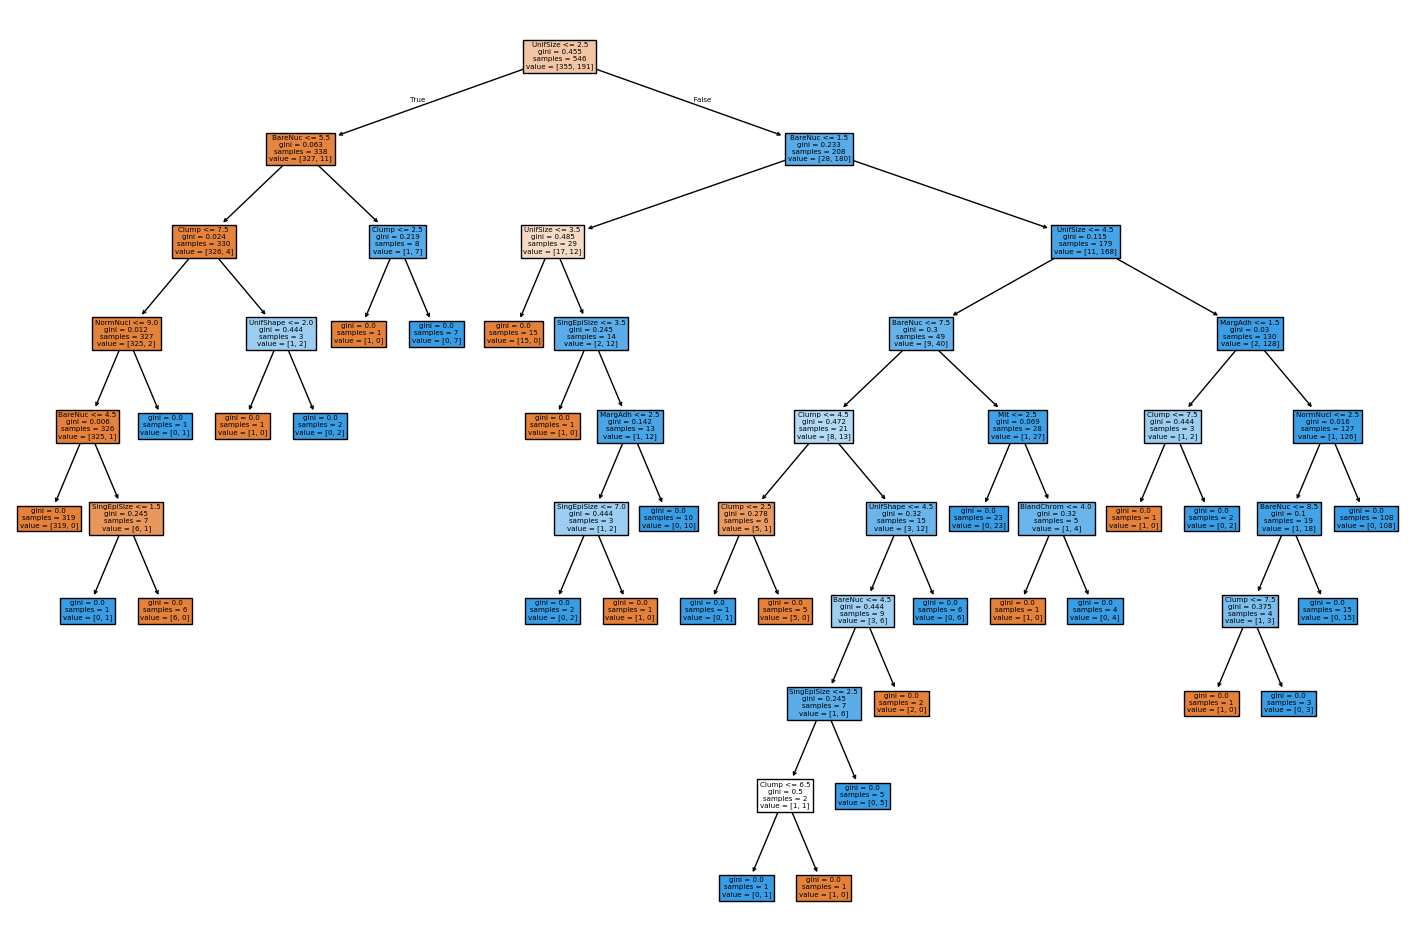

In [17]:
plot_decision_tree(model, feature_cols)

We can immediately see that this tree is quite large, and is likely overfitting. Let's do some paramettrization.

## Customizing the model

In [18]:
custom_model = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=3, random_state=123)
custom_model.fit(X_train, y_train.values.ravel())
preds = custom_model.predict(X_test)
evaluate_metrics(y_test, preds)

{'accuracy': 0.9635036496350365,
 'recall': 0.9166666666666666,
 'precision': 0.9777777777777777,
 'f1score': 0.946236559139785}

That is a little better, but not a great improvement. If we plot the tree, we can see it is simpler, with lower depth.

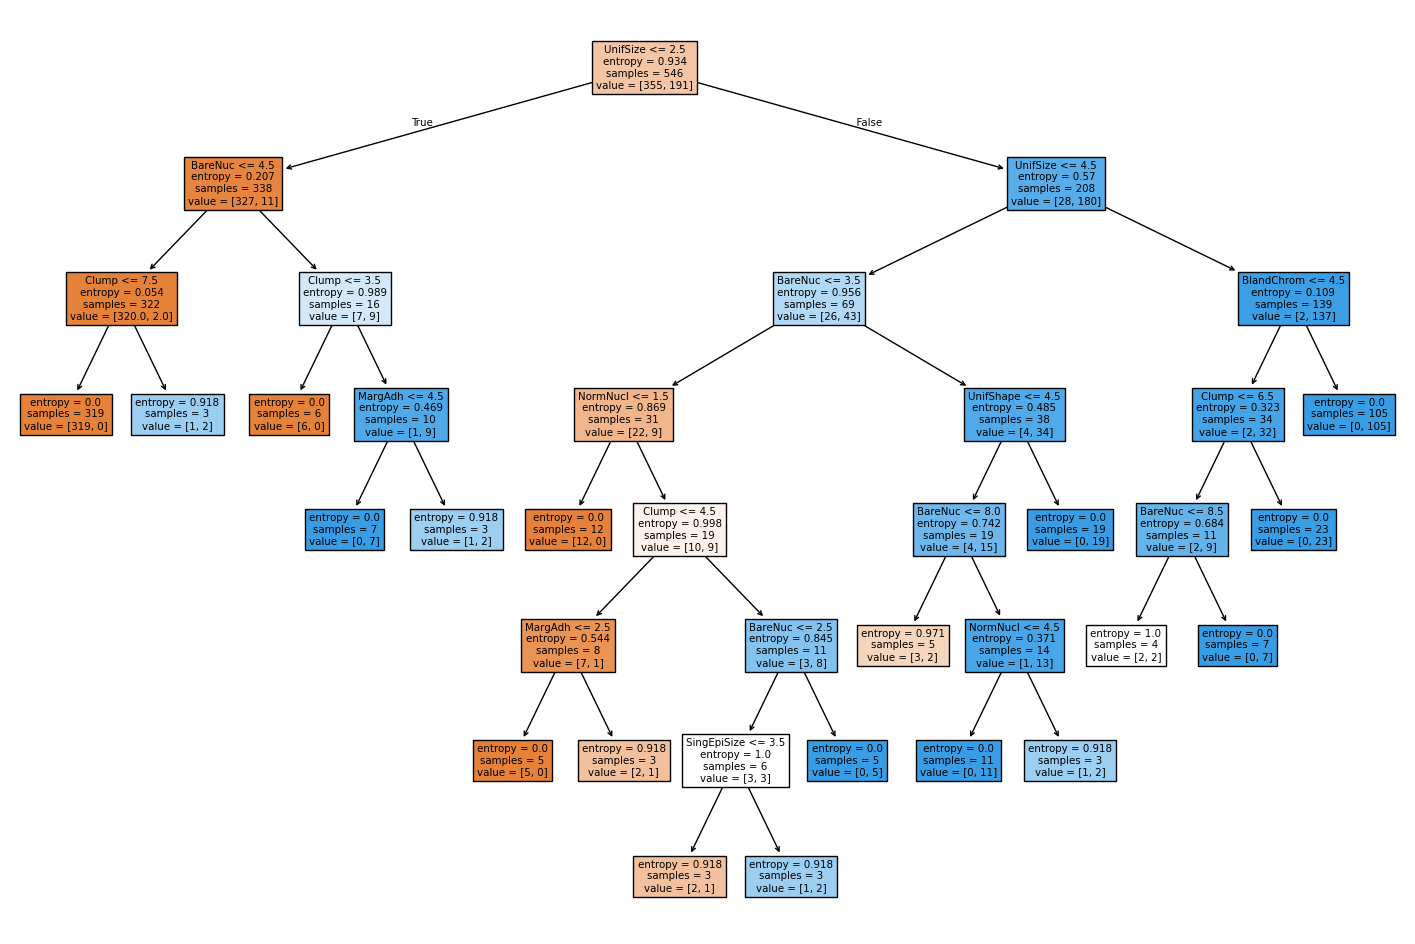

In [19]:
plot_decision_tree(custom_model, feature_cols)

Using the 'gini' criteria, and increasing the number of minimum samples per leaf, we can improve performane a bit more. Leading to a 97% accuracy and an f1-score of 0.95. 

In [20]:
custom_model = DecisionTreeClassifier(criterion='gini', max_depth=15, min_samples_leaf=5, random_state=123)
custom_model.fit(X_train, y_train.values.ravel())
preds = custom_model.predict(X_test)
evaluate_metrics(y_test, preds)

{'accuracy': 0.9708029197080292,
 'recall': 0.9791666666666666,
 'precision': 0.94,
 'f1score': 0.9591836734693877}

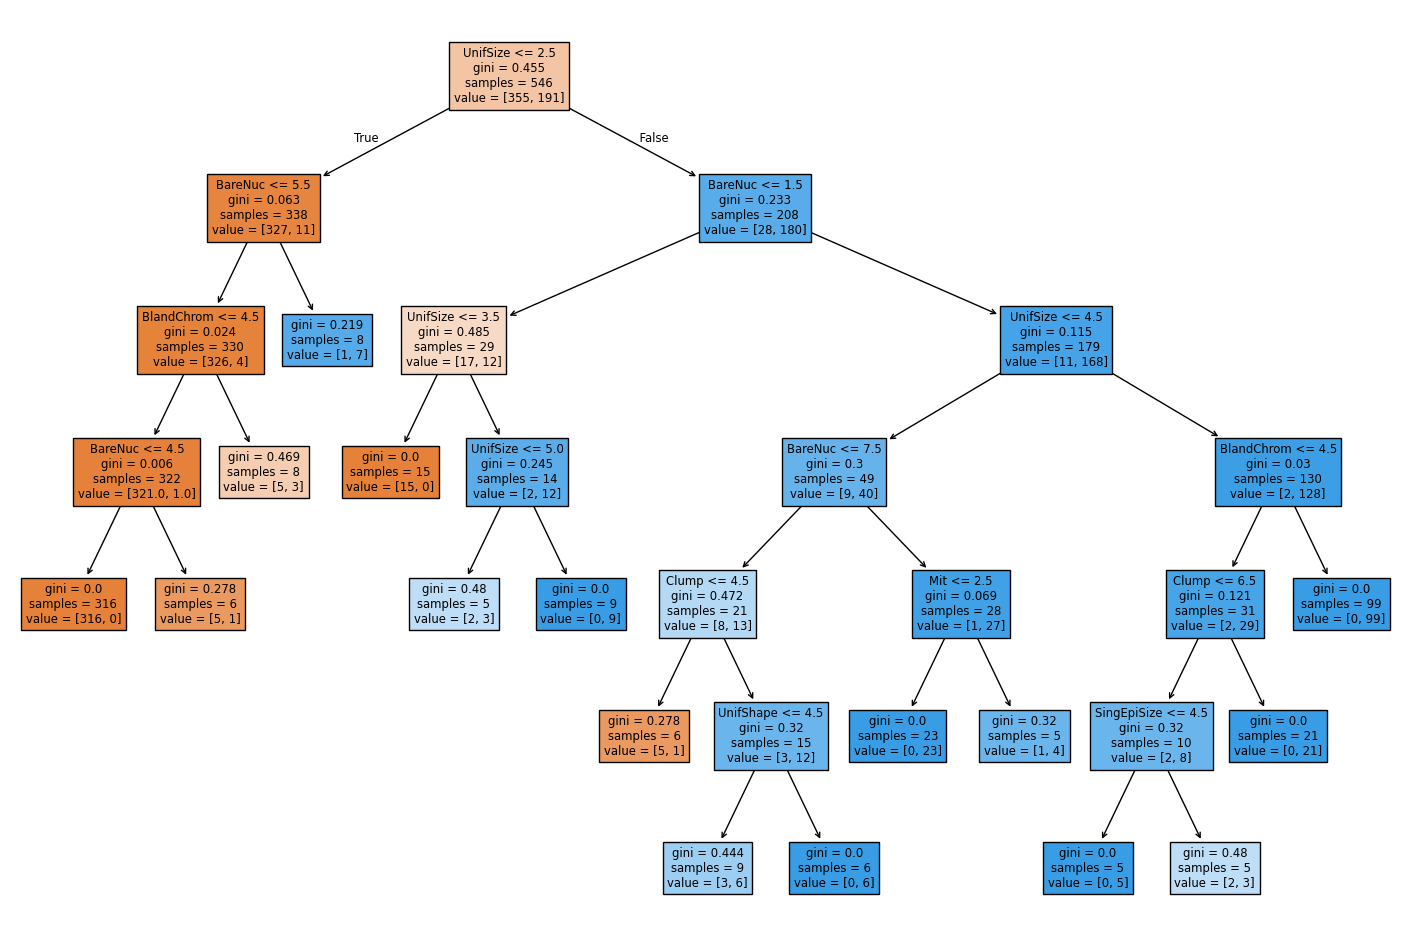

In [21]:
plot_decision_tree(custom_model, feature_cols)

## Hyperparameter tuning

Again, doing this manually is tedious and error prone, so let's use gridsearch to handle finding the optimal parameters for us.

In [22]:
params_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5]
}

model = DecisionTreeClassifier(random_state=123)
gs = GridSearchCV(model, param_grid=params_grid, scoring='f1', cv=5, verbose=2)
gs.fit(X_train, y_train)
best_params = gs.best_params_
best_params

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ....criterion=gini, max_depth=5, min_samples_leaf=1; total time=   0.0s
[CV] END ....criterion=gini, max_depth=5, min_samples_leaf=1; total time=   0.0s
[CV] END ....criterion=gini, max_depth=5, min_samples_leaf=1; total time=   0.0s
[CV] END ....criterion=gini, max_depth=5, min_samples_leaf=1; total time=   0.0s
[CV] END ....criterion=gini, max_depth=5, min_samples_leaf=1; total time=   0.0s
[CV] END ....criterion=gini, max_depth=5, min_samples_leaf=2; total time=   0.0s
[CV] END ....criterion=gini, max_depth=5, min_samples_leaf=2; total time=   0.0s
[CV] END ....criterion=gini, max_depth=5, min_samples_leaf=2; total time=   0.0s
[CV] END ....criterion=gini, max_depth=5, min_samples_leaf=2; total time=   0.0s
[CV] END ....criterion=gini, max_depth=5, min_samples_leaf=2; total time=   0.0s
[CV] END ....criterion=gini, max_depth=5, min_samples_leaf=5; total time=   0.0s
[CV] END ....criterion=gini, max_depth=5, min_s

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5}

That gives us something very close to what we last tried. The max depth is sligthly different, but in the end does not matter since it is not hit during training. Let's show what it looks like:

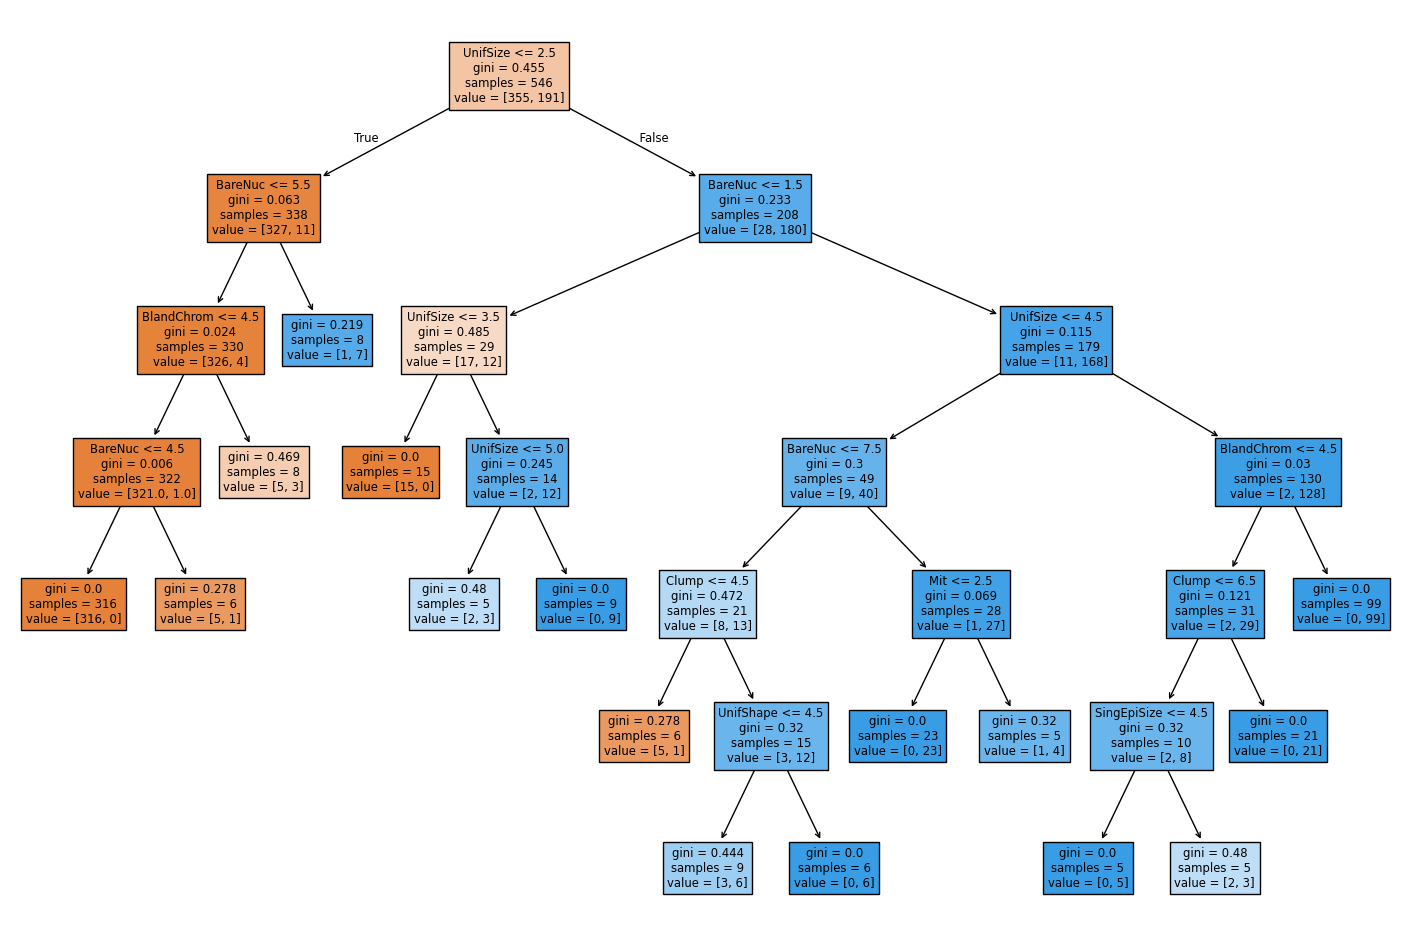

In [23]:
plot_decision_tree(gs.best_estimator_, feature_cols)